In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" какой GPU:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)
del x 

 CPU работает:
100 циклов: 352.32ms
 какой GPU:
100 циклов: 394.14ms
 CPU работает:
100 циклов: 347.32ms
 какой GPU:
100 циклов: 6.00ms


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import cv2 as cv
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline
import pandas as pd
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


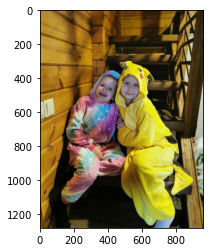

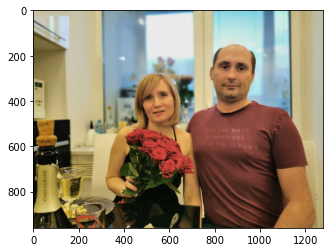

((1280, 960, 3), (960, 1280, 3))

In [58]:
im = cv.imread('images/1.jpg')
im_2 = cv.imread('images/2.jpg')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im_2 = cv.cvtColor(im_2, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
plt.imshow(im_2)
plt.show()
im.shape,im_2.shape

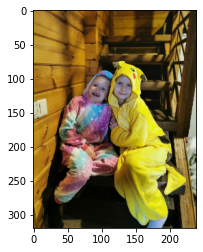

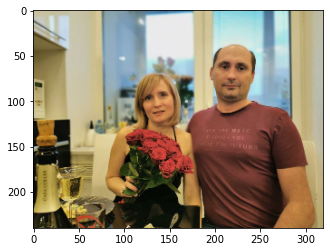

((320, 240, 3), (240, 320, 3))

In [29]:
n = 4
# размеры изображения
newH = int(im.shape[0]/n) #высота
newW = int(im.shape[1]/n) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
im_2 = cv.resize(im_2, (newH,newW)) 
#Выводим 

plt.imshow(im)
plt.show()
plt.imshow(im_2)
plt.show()
im.shape,im_2.shape

In [59]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [60]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 

sss.setBaseImage(im_2)
sss.switchToSelectiveSearchQuality()
rects_2 = sss.process() 

#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape,rects_2.shape) #число найденых объектов

(23444, 4) (18739, 4)


Для 1 го фото

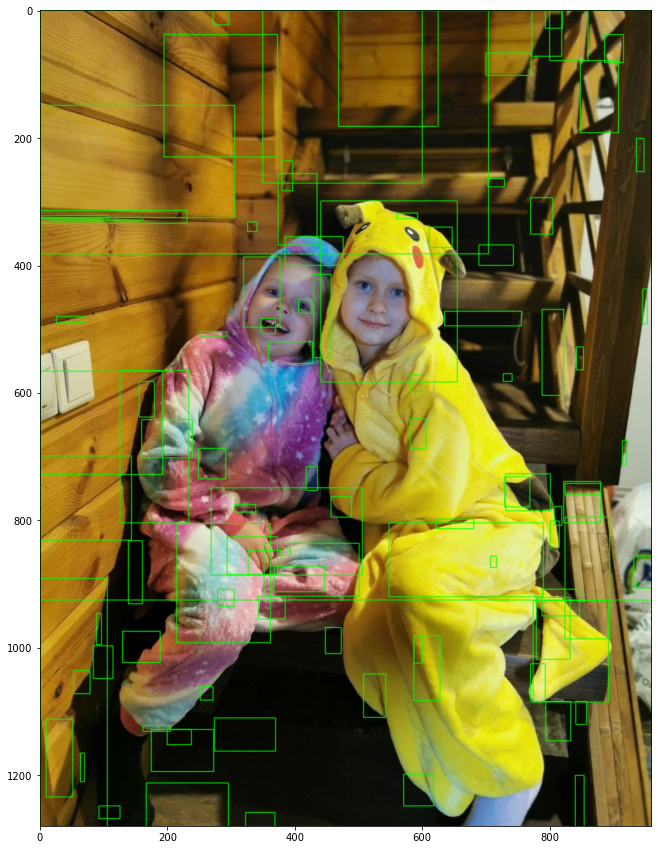

In [64]:
num_Rects = 100 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for  rect in rects[:num_Rects]: 
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 


# Рисуем на экран
plt.figure(figsize=(15,15))
plt.imshow(im_) 
plt.show()

Для 2 го фото

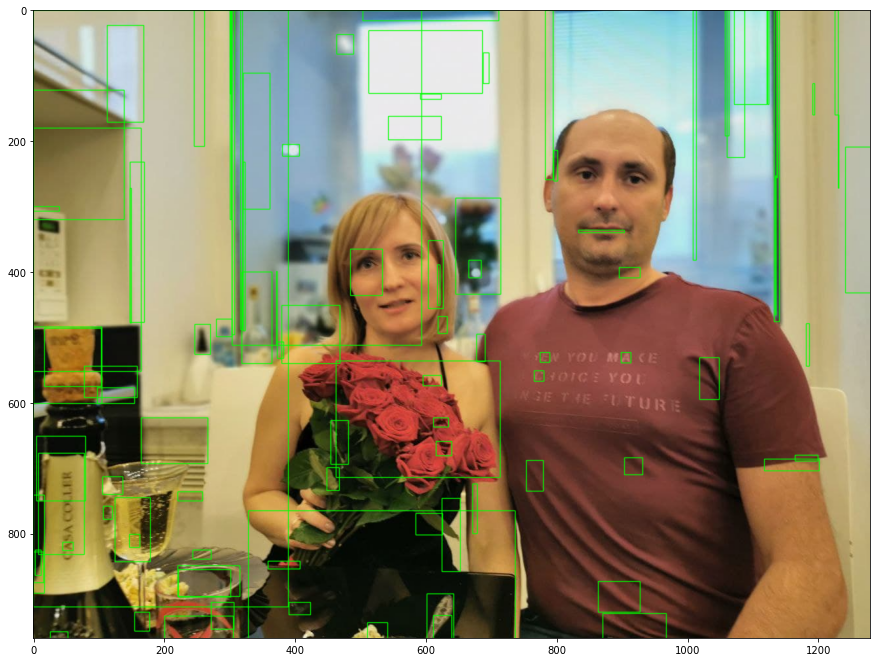

In [65]:
num_Rects = 100 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im_2.copy()

for  rect in rects_2[:num_Rects]: 
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 


# Рисуем на экран
plt.figure(figsize=(15,15))
plt.imshow(im_) 
plt.show()

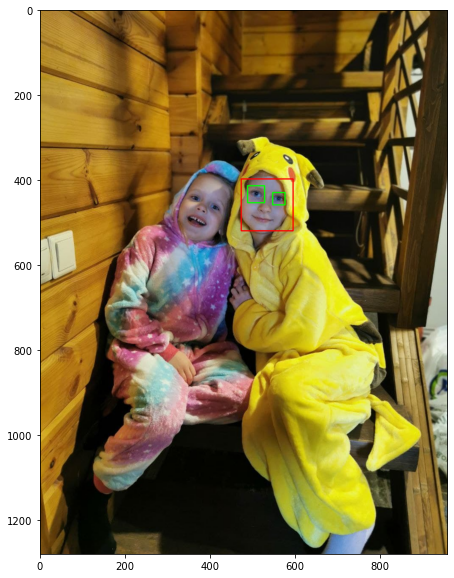

In [80]:
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')


# gray = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
gray= im.copy()
faces = face_cascade.detectMultiScale(gray, scaleFactor =1.5, minNeighbors =3)


for (x,y,w,h) in faces:
    cv.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(gray)      
plt.show()  

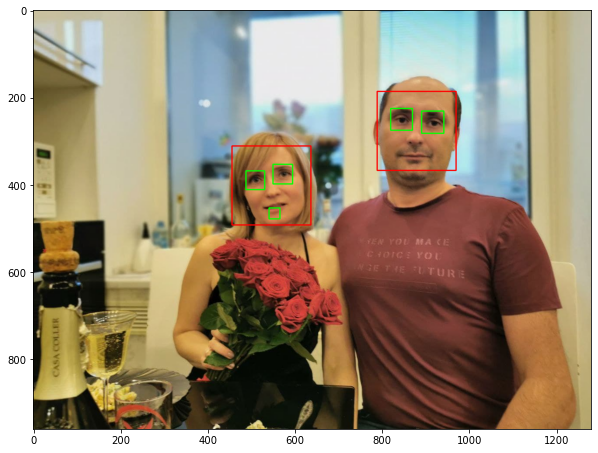

In [122]:
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')
gray = im_2.copy()
faces = face_cascade.detectMultiScale(gray, scaleFactor =1.4, minNeighbors =7)

for (x,y,w,h) in faces:
    cv.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_gray,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(gray)      
plt.show()  

Посмотрим на детекоторы

In [126]:
import time

In [134]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [132]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [130]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
        
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [128]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [136]:
def run_detector(detector, path,max_boxes=3, min_score=0.01):
    img = load_img(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key,value in result.items()} 
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"],
        max_boxes=max_boxes, min_score=min_score)

    display_image(image_with_boxes)
    return result

In [124]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


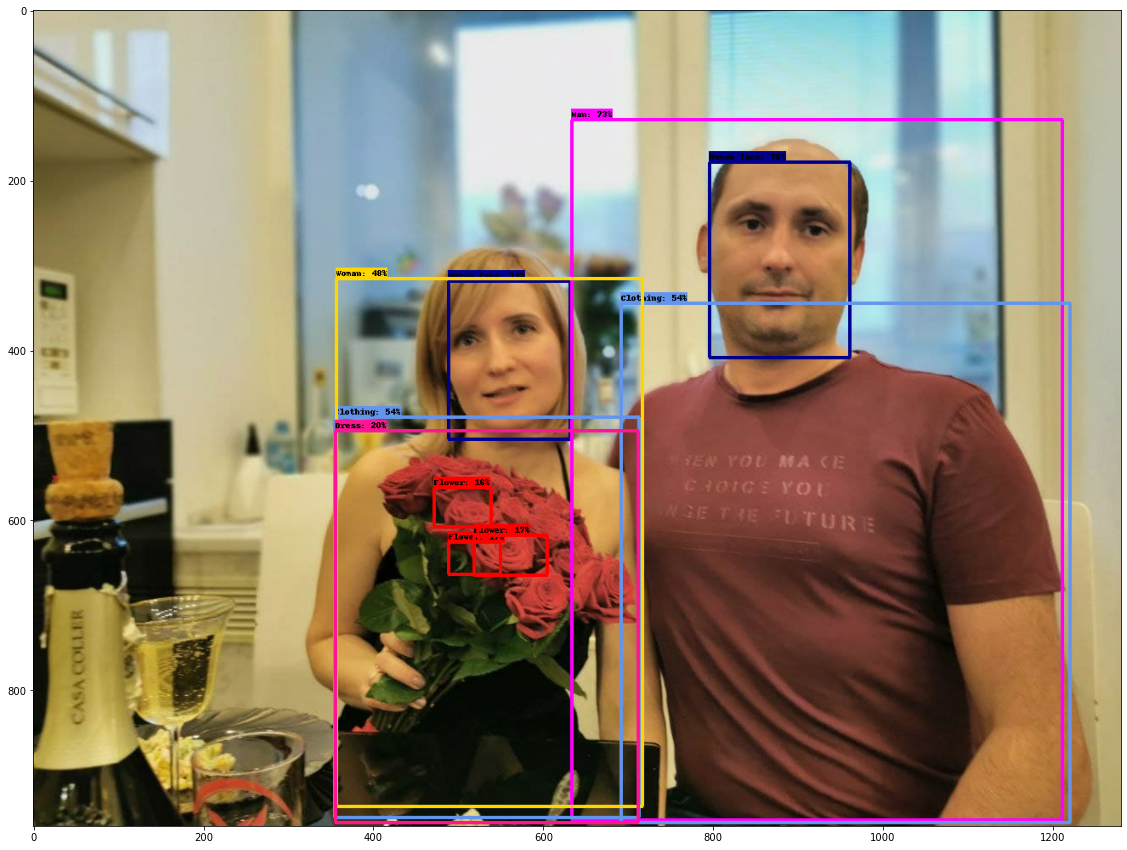

In [148]:
result = run_detector(detector = detector,path = 'images/2.jpg', max_boxes=10, min_score=0.15)

In [146]:
list(zip(result['detection_class_entities'][:10],result['detection_scores']))

[(b'Human face', 0.7624207),
 (b'Human face', 0.738649),
 (b'Man', 0.73059285),
 (b'Clothing', 0.5479206),
 (b'Clothing', 0.5412676),
 (b'Woman', 0.48256),
 (b'Dress', 0.20337167),
 (b'Flower', 0.1796547),
 (b'Flower', 0.1744452),
 (b'Flower', 0.16873252)]

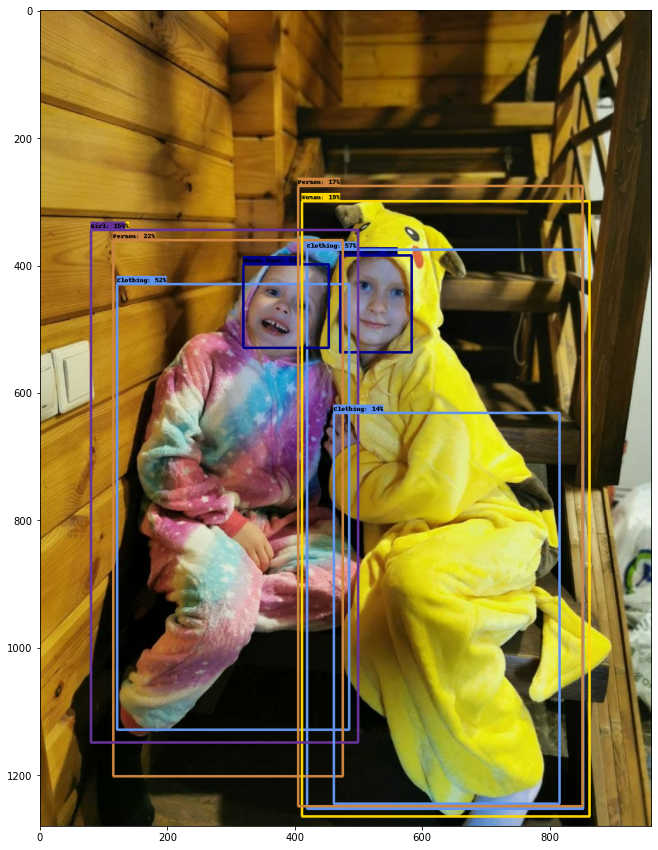

In [153]:
result = run_detector(detector = detector,path = 'images/1.jpg', max_boxes=10, min_score=0.13)

In [152]:
list(zip(result['detection_class_entities'][:10],result['detection_scores']))

[(b'Human face', 0.5991957),
 (b'Clothing', 0.57505757),
 (b'Clothing', 0.5278892),
 (b'Human face', 0.5186486),
 (b'Person', 0.22986655),
 (b'Woman', 0.2057956),
 (b'Woman', 0.19644164),
 (b'Person', 0.17141896),
 (b'Girl', 0.15167274),
 (b'Clothing', 0.14405948)]

Попоробуем другую сеть

In [154]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


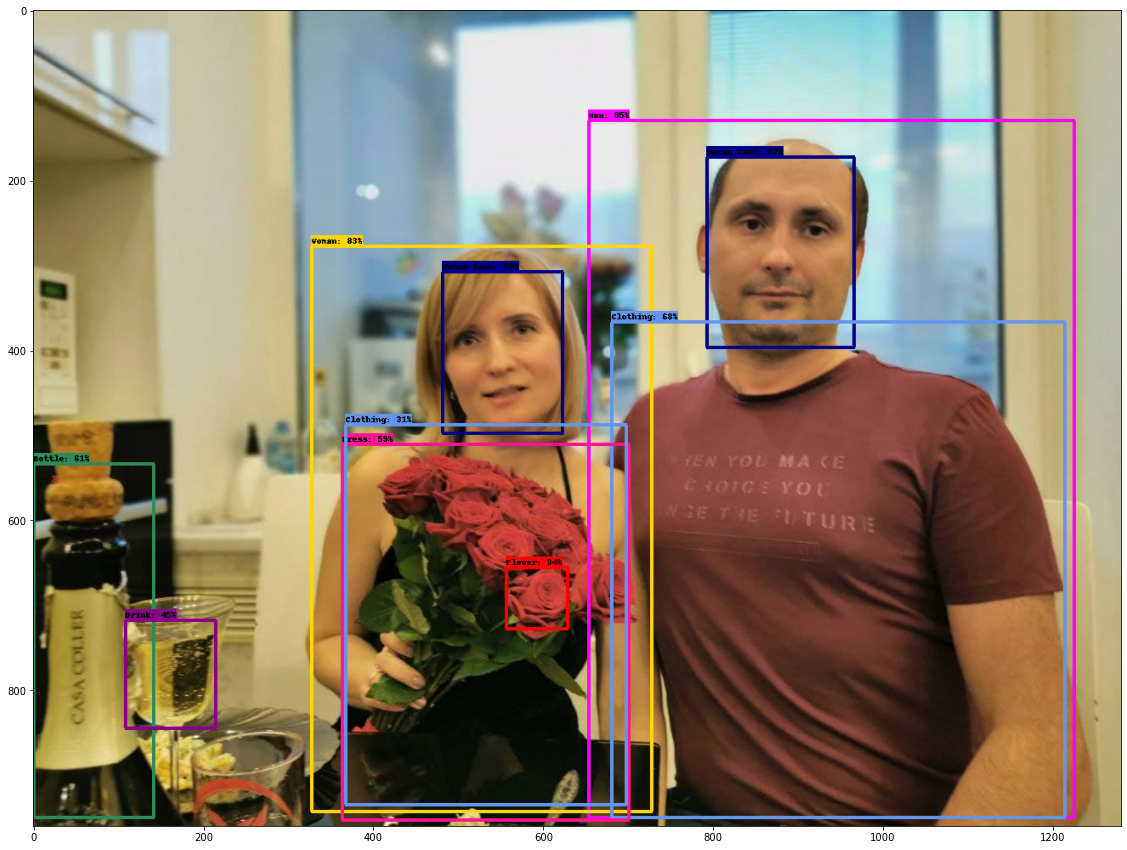

In [155]:
result = run_detector(detector = detector,path = 'images/2.jpg', max_boxes=10, min_score=0.15)

In [156]:
list(zip(result['detection_class_entities'][:10],result['detection_scores']))

[(b'Man', 0.95604104),
 (b'Human face', 0.89286786),
 (b'Human face', 0.87203246),
 (b'Woman', 0.8312514),
 (b'Clothing', 0.6878384),
 (b'Bottle', 0.6120505),
 (b'Dress', 0.5972312),
 (b'Drink', 0.45702797),
 (b'Flower', 0.3448021),
 (b'Clothing', 0.31741023)]

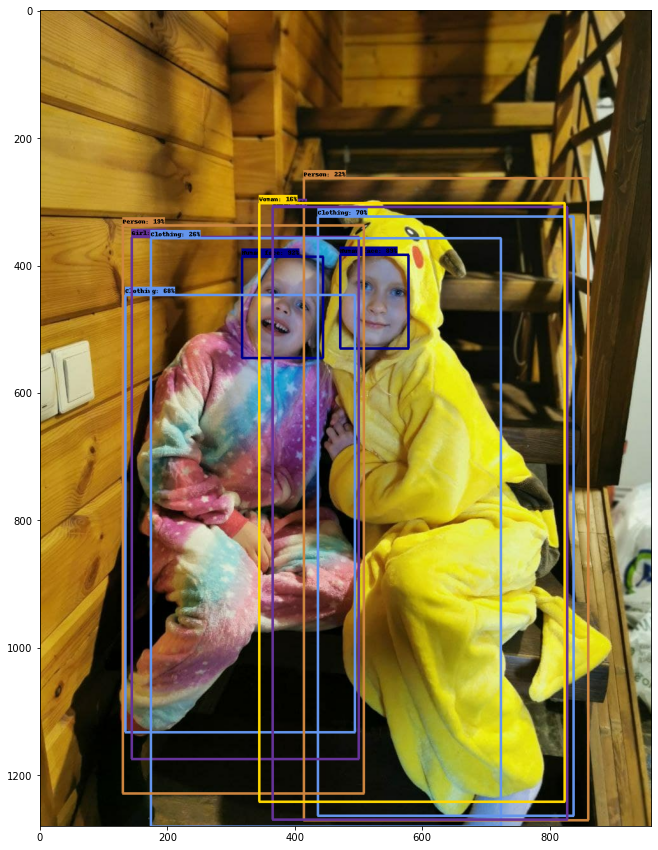

In [157]:
result = run_detector(detector = detector,path = 'images/1.jpg', max_boxes=10, min_score=0.13)

In [158]:
list(zip(result['detection_class_entities'][:10],result['detection_scores']))

[(b'Human face', 0.9203661),
 (b'Human face', 0.8963234),
 (b'Clothing', 0.7011447),
 (b'Clothing', 0.6895782),
 (b'Girl', 0.46026516),
 (b'Clothing', 0.26002124),
 (b'Person', 0.22440182),
 (b'Person', 0.19176726),
 (b'Girl', 0.18379526),
 (b'Woman', 0.16391408)]

faster_rcnn конечно гораздо круче, но дольше